# Modeling Graphene/MAC/Graphene Heterostructure using the ballistic transport model

$$I = \alpha \int_{-\infty}^{\infty} D_1(E + eV / 2 + e V_g) D_2(E-eV / 2) T(E) [f(E + eV / 2) - f(E-eV / 2)] dE,$$

where $\alpha$ is a constant, $D_1(E)$ and $D_2(E)$ are the density of states of the two graphene electrodes, $f(E)$ is the Fermi-Dirac distribution function, $T(E)$ is the transmission probability of the barrier, and $V$ is the bias - source-drain - voltage.

The $T(E)$ is considered to be zero within a small bandgap and one outside the bandgap. Ref: [Theory of graphene–insulator–graphene tunnel junctions](http://dx.doi.org/10.1116/1.4871760), [Field-Effect Tunneling Transistor Based on Vertical Graphene Heterostructures](https://doi-org.libproxy1.nus.edu.sg/10.1126/science.1218461)

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import tqdm.notebook as tqdm

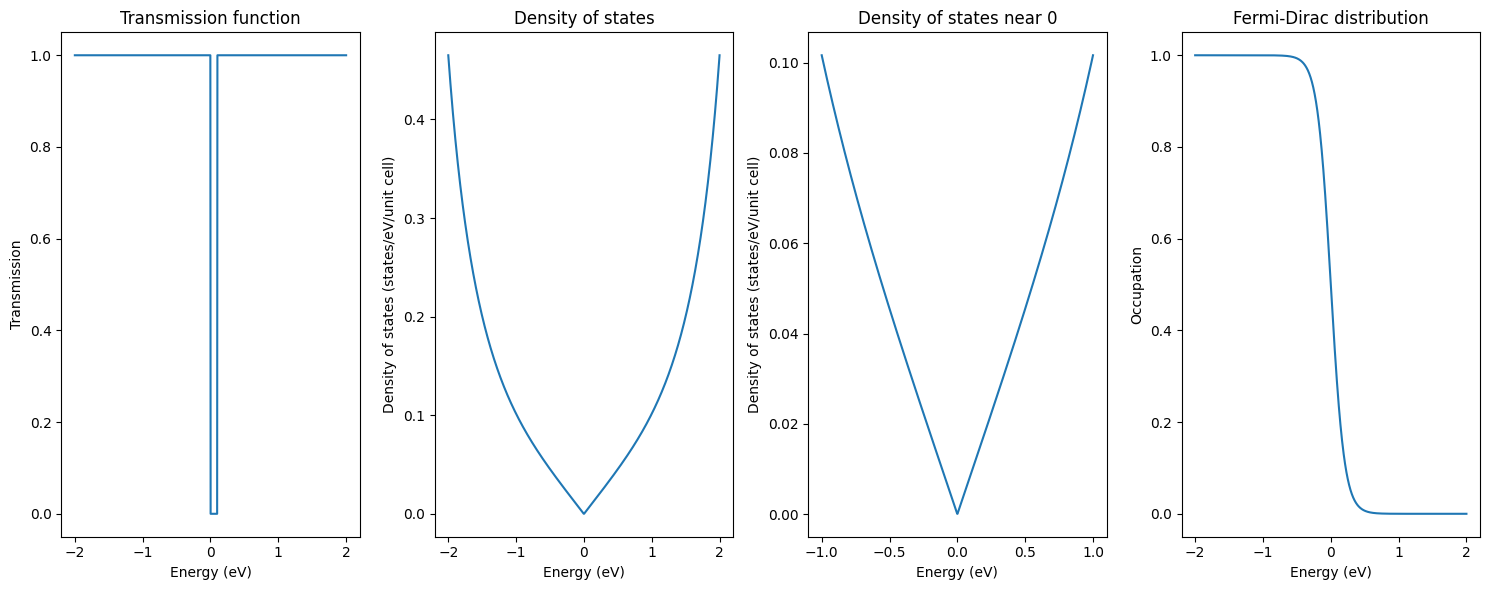

In [81]:
# Fermi-Dirac distribution
def f(E, T):
    return 1 / (np.exp(E / T) + 1)

#Graphene DOS
@np.vectorize
def DOS(E):
    """
    Calculate the density of states for graphene including Van Hove singularities
    
    Parameters:
    E (float or numpy.array): Energy in eV
    
    Returns:
    float or numpy.array: Density of states in states/(eV·unit_cell)
    """
    # Constants
    hbar = 6.582119e-16  # eV·s
    vf = 1e6  # m/s
    a = 2.46e-10  # lattice constant in m
    
    # Reference energies
    E0 = 1.0  # eV
    E_VH = 2.7  # eV
    
    # Correction parameters
    alpha = 0.05
    beta = 0.08
    
    # Base linear DOS
    DOS_linear = 2 * np.abs(E) / (np.pi * (hbar * vf)**2)
    
    # Correction terms
    quadratic_term = alpha * (E/E0)**2
    cubic_term = beta * np.abs(E/E0)**3
    
    # Van Hove singularity term (with regularization to avoid division by zero)
    epsilon = 1e-3  # small number for regularization
    VH_term = 1 / (np.abs(1 - (E/E_VH)**2) + epsilon)
    
    # Complete correction function
    f_E = quadratic_term + cubic_term * VH_term
    
    # Total DOS
    DOS_total = DOS_linear * (1 + f_E)
    
    # Convert to states/(eV·unit_cell)
    DOS_total *= (a**2)  # Convert from m^-2 to states per unit cell
    return DOS_total


# Transmission function
def T(E, gap=0.2):
    return 1 - np.heaviside(E, -gap/2) * np.heaviside(gap/2 - E, -gap/2)
    # return 1 - (f(E, 0.01) * (1 - f(E, 0.01))) / max(f(E, 0.01) * (1 - f(E, 0.01)))
E_grid = np.linspace(-2, 2, 1000)
T_grid = T(E_grid)
DOSE_grid = DOS(E_grid)
f_grid = f(E_grid, 0.1)

fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].plot(E_grid, T_grid, label='Transmission function')
ax[0].set_xlabel('Energy (eV)')
ax[0].set_ylabel('Transmission')
ax[0].set_title('Transmission function')

ax[1].plot(E_grid, DOSE_grid, label='Density of states')
ax[1].set_xlabel('Energy (eV)')
ax[1].set_ylabel('Density of states (states/eV/unit cell)')
ax[1].set_title('Density of states')

ax[2].plot(np.linspace(-1, 1, 1000), DOS(np.linspace(-1, 1, 1000)), label='Density of states')
ax[2].set_xlabel('Energy (eV)')
ax[2].set_ylabel('Density of states (states/eV/unit cell)')
ax[2].set_title('Density of states near 0')

ax[3].plot(E_grid, f_grid, label='Fermi-Dirac distribution')
ax[3].set_xlabel('Energy (eV)')
ax[3].set_ylabel('Occupation')
ax[3].set_title('Fermi-Dirac distribution')

plt.tight_layout()

In [82]:
# VAC calculation function
def I(V, grid, Temp = 0.025):
    r = DOS(grid - V/2) * DOS(grid + V / 2) * T(grid) * (f(grid - V/2, Temp) - f(grid + V/2, Temp))
    return np.trapezoid(r, grid)

In [97]:
def I_gated(V, grid, Temp = 0.025, Vgate = 0):
    r = DOS(grid - V / 2 + Vgate) * DOS(grid + V / 2) * T(grid + Vgate) * (f(grid - V / 2, Temp) - f(grid + V / 2, Temp))
    return np.trapezoid(r, grid)

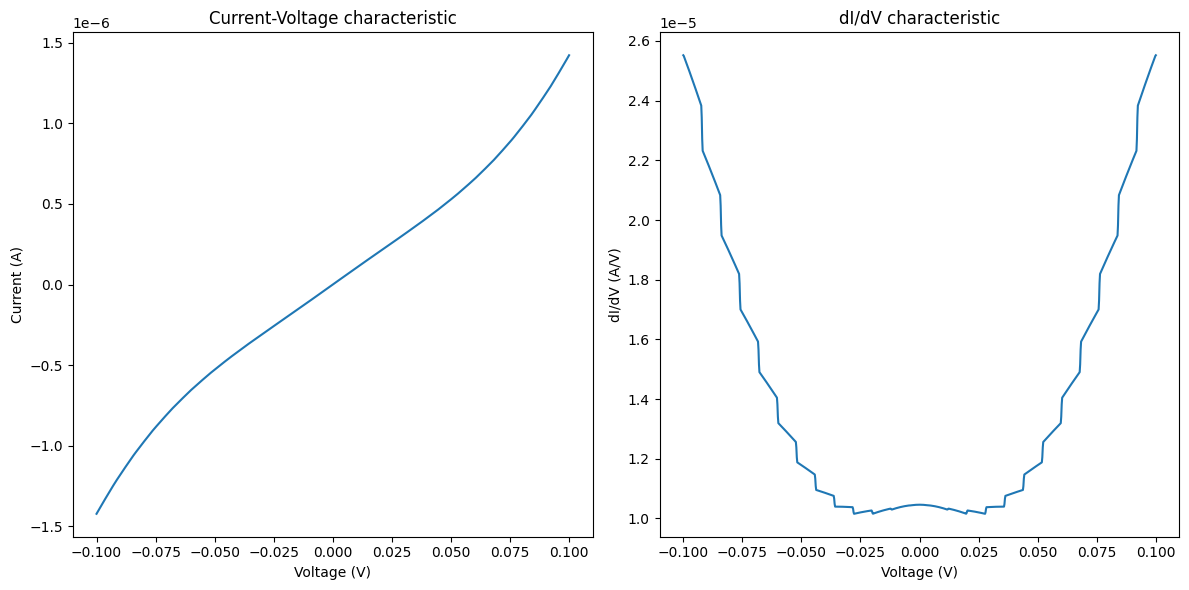

In [98]:
v_grid = np.linspace(-0.1, 0.1, 1000)
I_grid = np.array([I(V, E_grid) for V in v_grid])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(v_grid, I_grid, label='Current')
ax[0].set_xlabel('Voltage (V)')
ax[0].set_ylabel('Current (A)')
ax[0].set_title('Current-Voltage characteristic');

I_derivative = np.gradient(I_grid, v_grid)

ax[1].plot(v_grid, I_derivative, label='dI/dV')
ax[1].set_xlabel('Voltage (V)')
ax[1].set_ylabel('dI/dV (A/V)')
ax[1].set_title('dI/dV characteristic');

plt.tight_layout()

/var/folders/gx/h6bdq2b90cq1tkcjmmsmvzzh0000gn/T/ipykernel_14765/2810058973.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1 / (np.exp(E / T) + 1)


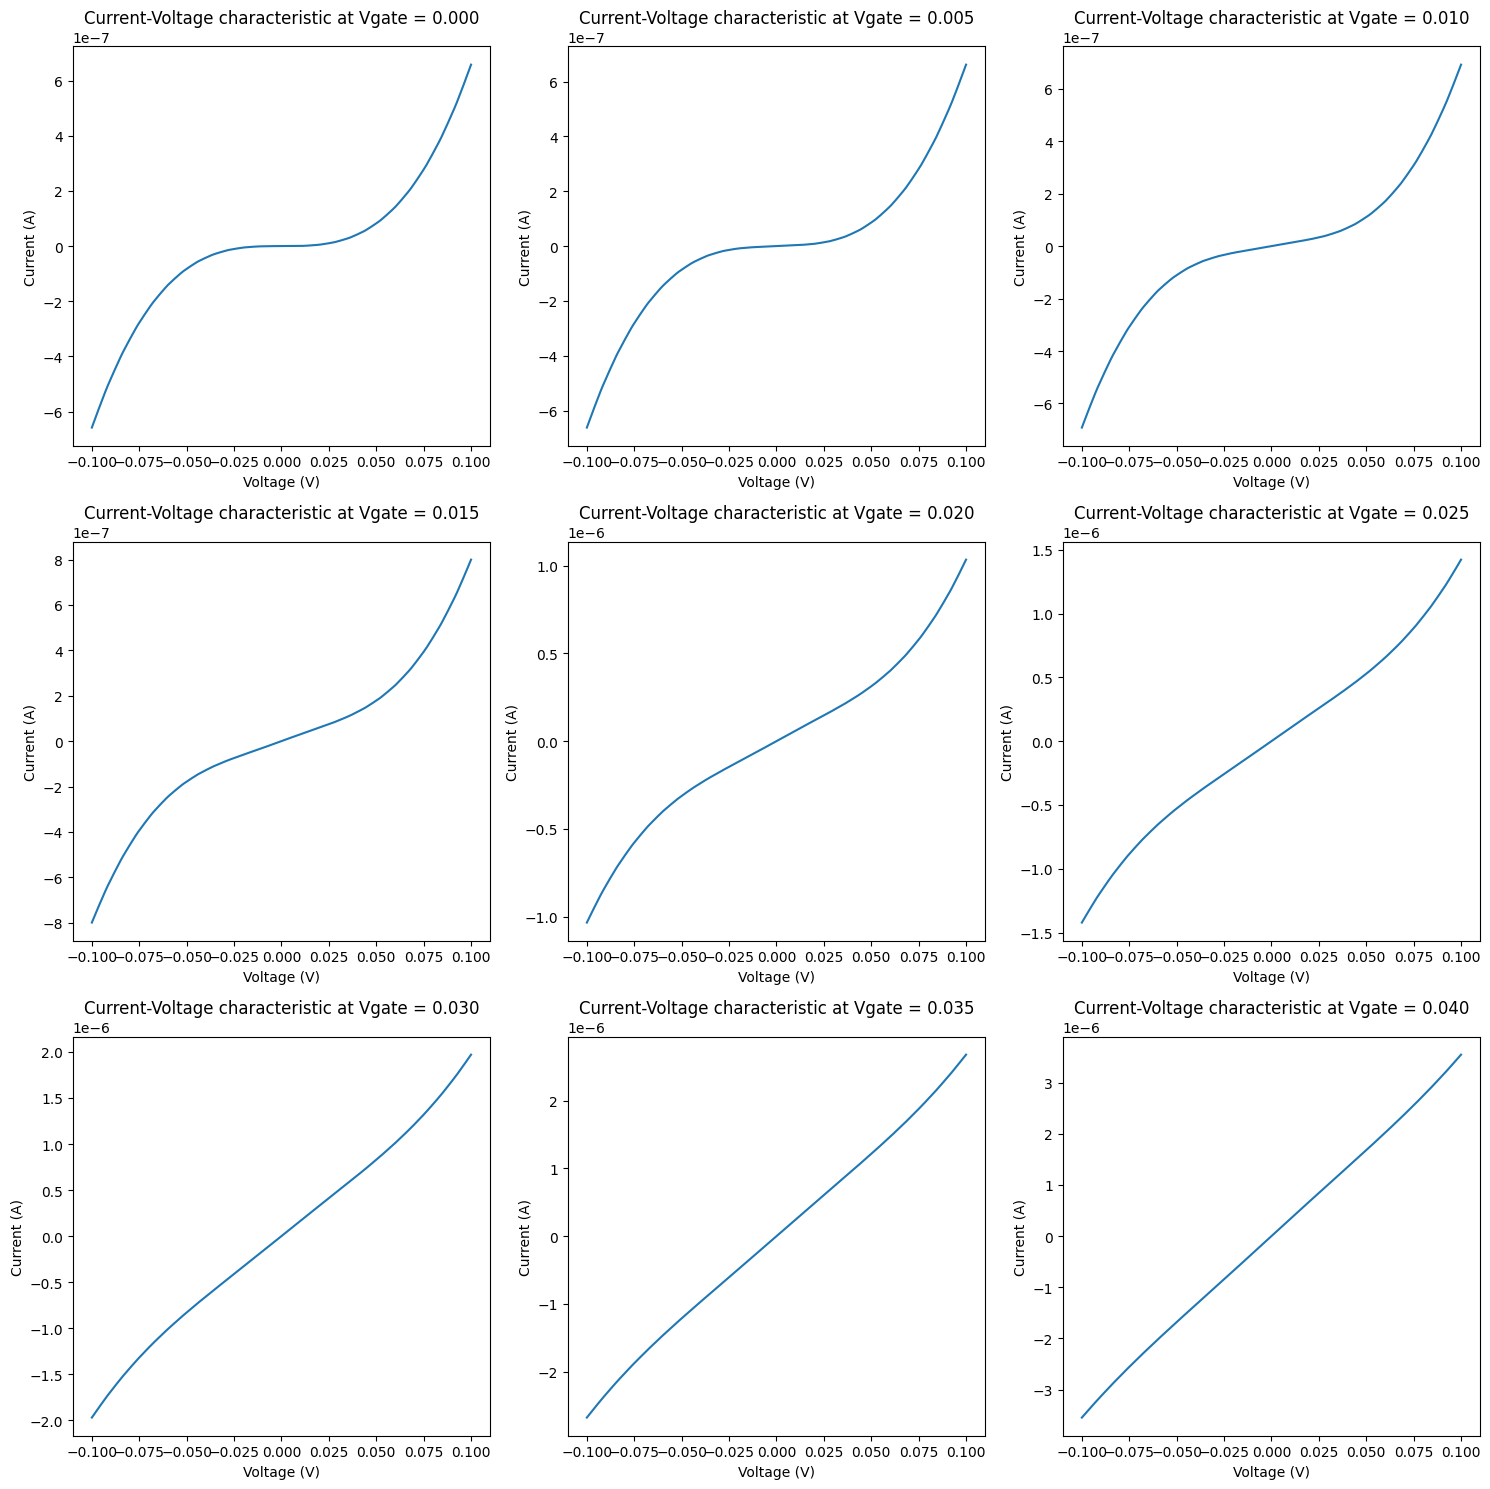

In [104]:
Vgate = np.linspace(0, 0.04, 9)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax1 = ax.flatten()
for i in range(9):
    I_grid = np.array([I_gated(V, E_grid, Vgate[i]) for V in v_grid])
    ax1[i].plot(v_grid, I_grid, label='Current')
    ax1[i].set_xlabel('Voltage (V)')
    ax1[i].set_ylabel('Current (A)')
    ax1[i].set_title(f'Current-Voltage characteristic at Vgate = {Vgate[i]:.3f}')
plt.tight_layout()

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/gx/h6bdq2b90cq1tkcjmmsmvzzh0000gn/T/ipykernel_14765/2810058973.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1 / (np.exp(E / T) + 1)
/var/folders/gx/h6bdq2b90cq1tkcjmmsmvzzh0000gn/T/ipykernel_14765/1716194847.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = so.curve_fit(line, v_grid_small, I_grid)


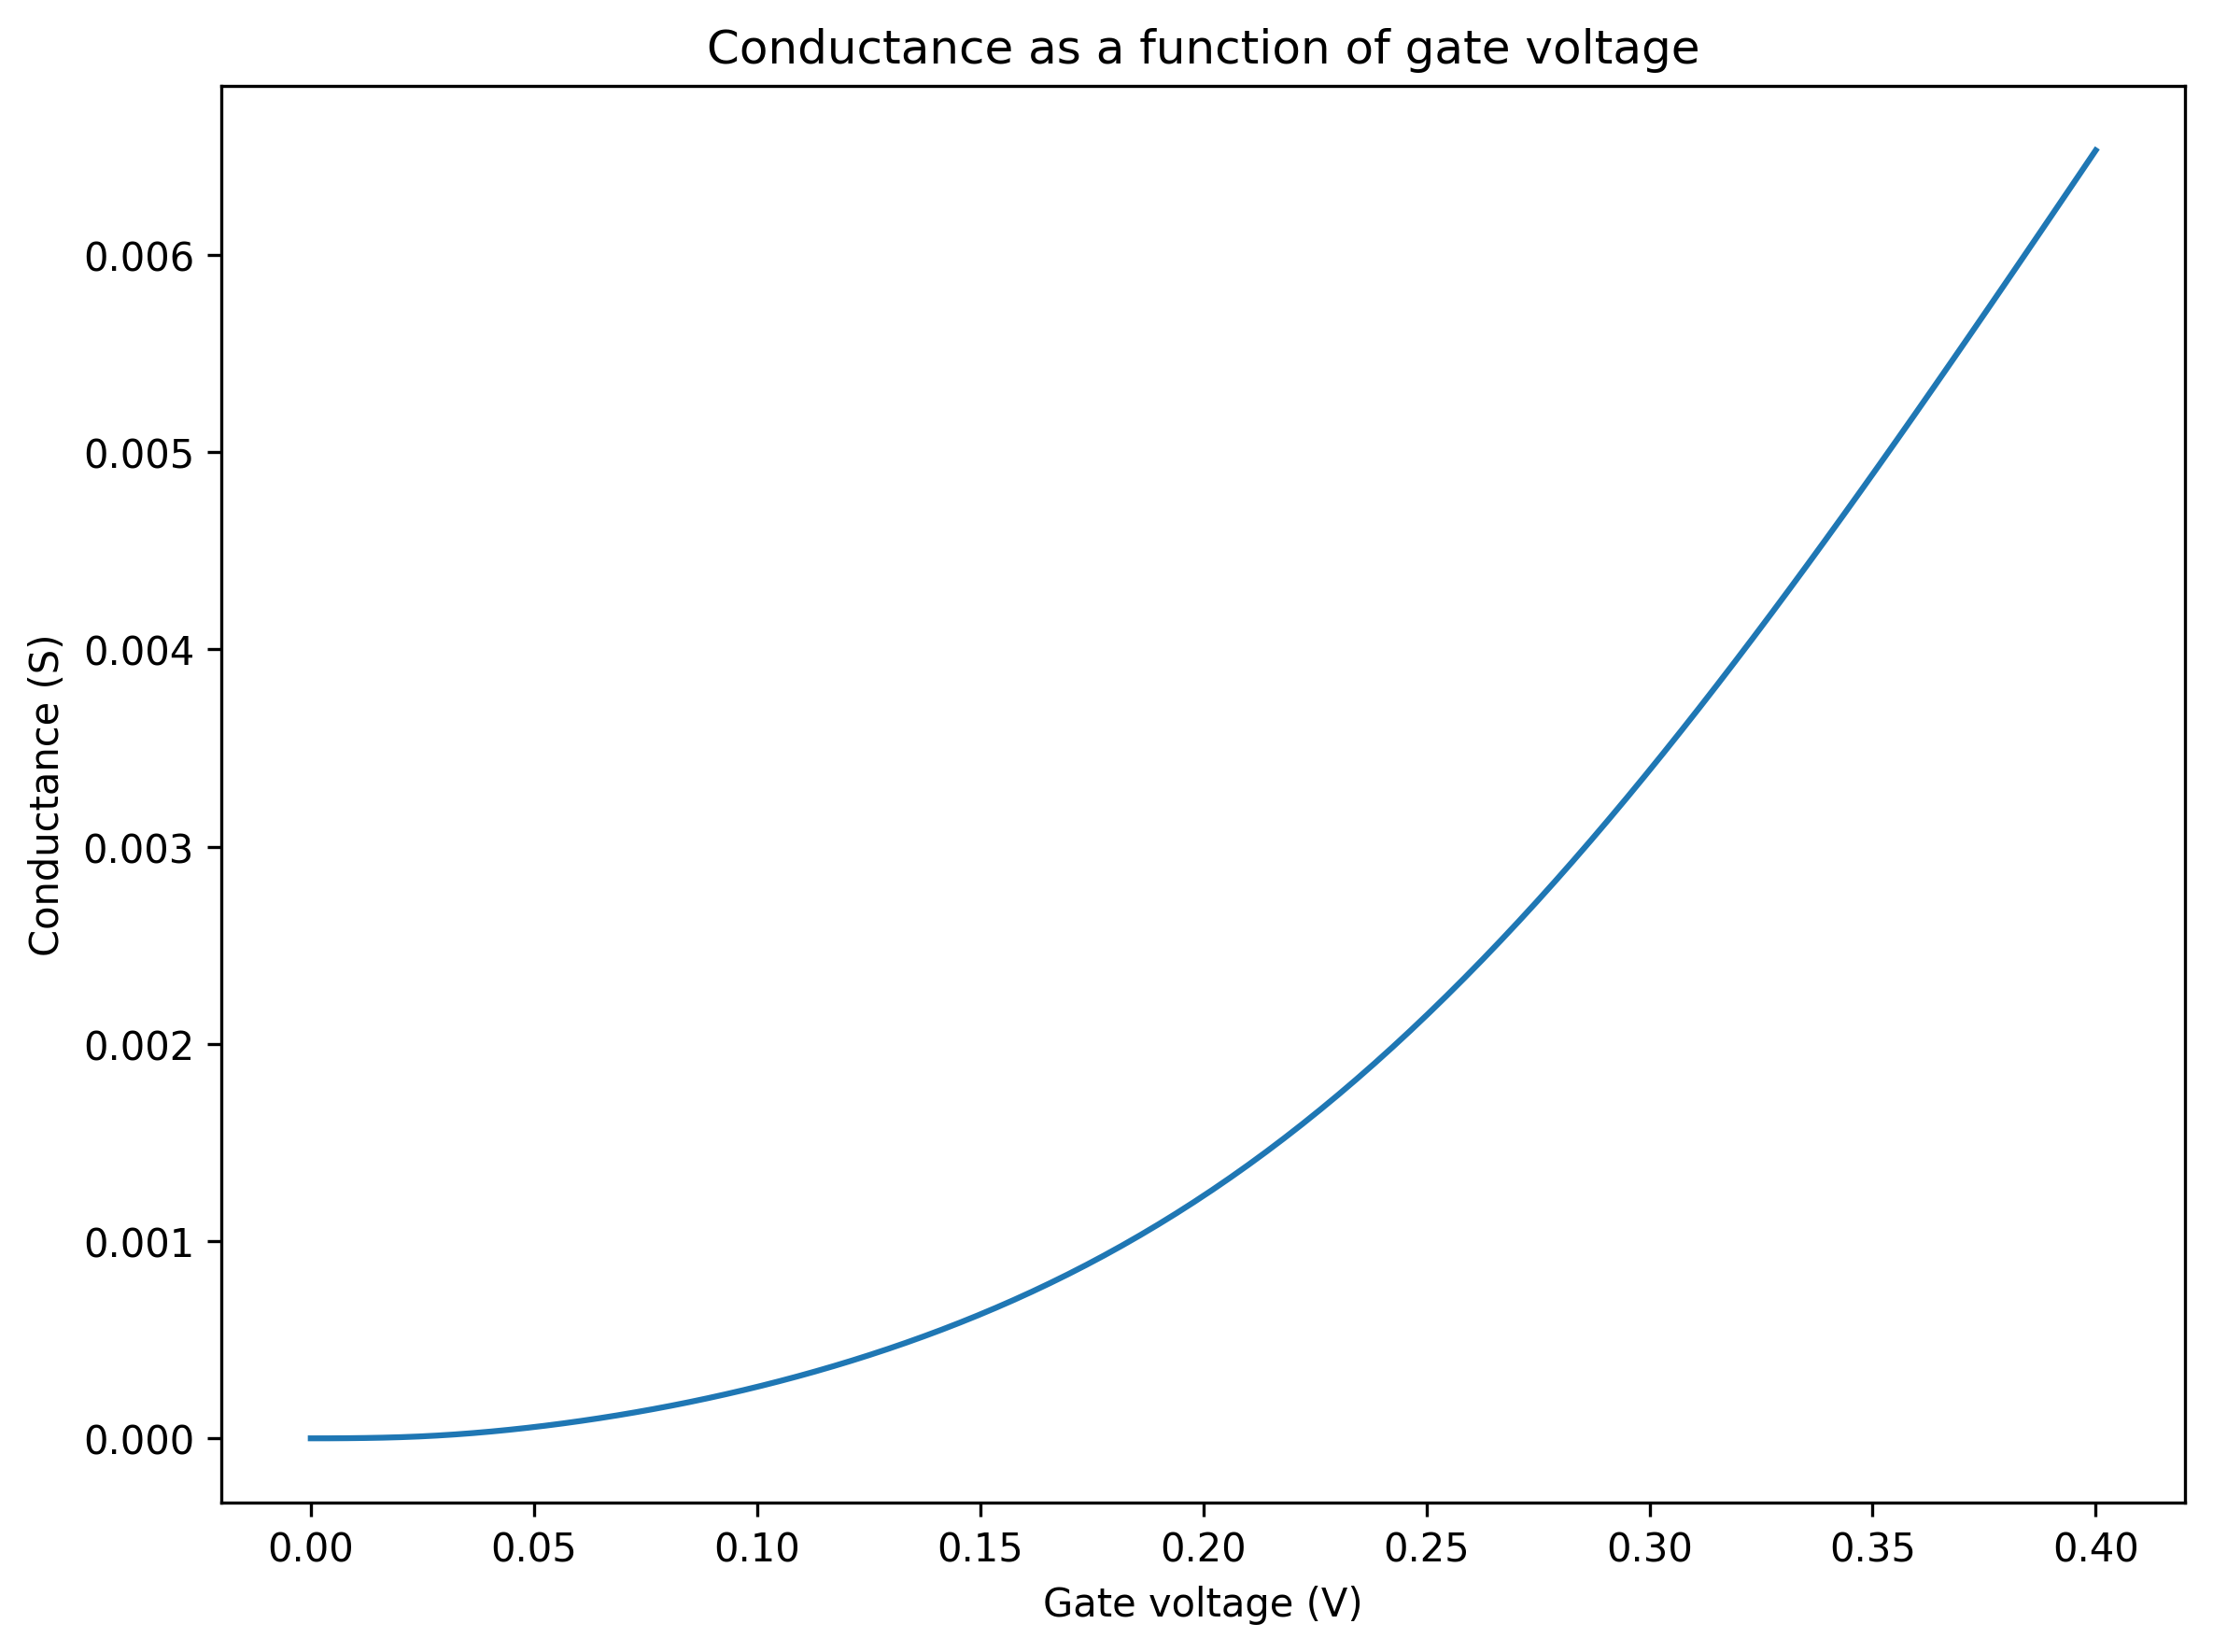

In [116]:
Vgate_grid = np.linspace(0, 0.4, 100)
v_grid_small = np.linspace(-0.02, 0.02, 100)
sigma = np.zeros_like(Vgate_grid)
line = lambda x, a, b: a * x + b

for i, Vgate in enumerate(tqdm.tqdm(Vgate_grid)):
    I_grid = np.array([I_gated(V, E_grid, Vgate) for V in v_grid_small])
    popt, _ = so.curve_fit(line, v_grid_small, I_grid)
    sigma[i] = popt[0]
    
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(Vgate_grid, sigma, label='Conductance')
plt.xlabel('Gate voltage (V)')
plt.ylabel('Conductance (S)')
plt.title('Conductance as a function of gate voltage')
plt.tight_layout()